## Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
import statsmodels.formula.api as smf
import statsmodels.api as sm
import piecewise_regression as pwr
import libpysal
import shapely
import contextily as cx


from scipy import stats 
from IPython.core.pylabtools import figsize
from pointpats import centrography
from pointpats import distance_statistics
from shapely.geometry import Point
from tobler.util import h3fy
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import plot_local_autocorrelation
from geopy.geocoders import Nominatim  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
import shapely

from scipy import stats 
from IPython.core.pylabtools import figsize
from pointpats import distance_statistics
#from shapely.geometry import Point
from tobler.util import h3fy
from pysal.lib import weights
from pysal.explore import esda
#from splot.esda import plot_local_autocorrelation

C:\Users\kevin\AppData\Local\Temp\ipykernel_4040\335366160.py:5: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
C:\Users\kevin\miniconda3\envs\info615\lib\site-packages\spaghetti\network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change i

## Data Gathering

In [2]:
#Loading the CSV that contains identified last-mile warehouses into a dataframe
df = pd.read_csv(r"G:\My Drive\INFO-615  Spatial Statistics GIS\Final Assignment\DATA\NYCLast-MileWarehouses.csv")

In [3]:
#Getting the boundaries for the five boroughs
borosURL = "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON"
boros = gpd.read_file(borosURL)

In [4]:
#This data set consists of 6 classes of zoning features: zoning districts, special purpose districts, 
#special purpose district subdistricts, limited height districts, commercial overlay districts, 
#and zoning map amendments.
zonesURL = "https://data.cityofnewyork.us/api/geospatial/kdig-pewd?method=export&format=GeoJSON"
zones = gpd.read_file(zonesURL)

## Data Wrangling

In [5]:
#Create geodataframe of identified last-mile warehouses
geoms = gpd.points_from_xy(df['Longitude'], df['Latitude'])
gdf = gpd.GeoDataFrame(df.copy(), geometry = geoms, crs=4326)

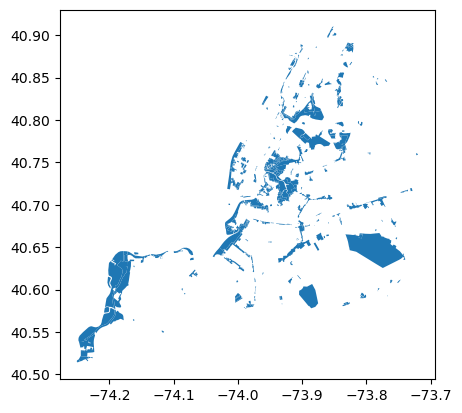

In [6]:
#Create geodataframe of manufacturing zones 
zonesM = zones.copy()[zones['zonedist'].str.contains('M', regex=True, na=False)]
zonesM.plot();

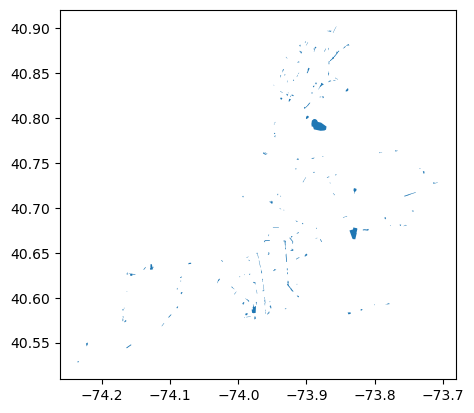

In [7]:
#Create geodataframe of C8 zones 
zonesC8 = zones.copy()[zones['zonedist'].str.contains('C8', regex=True, na=False)]
zonesC8.plot();

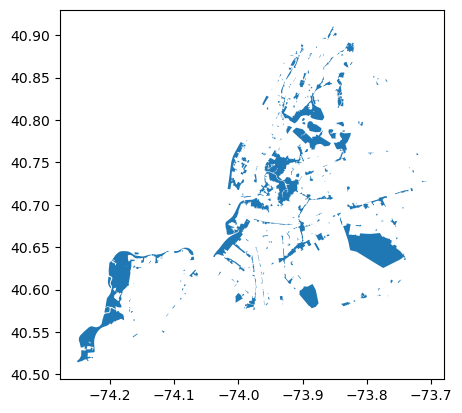

In [8]:
# Concatenate manufacturing zones and C8 zones into a single GeoDataFrame
zonesMandC8 = pd.concat([zonesM, zonesC8]).dissolve()
zonesMandC8.plot();

### Data Viewing

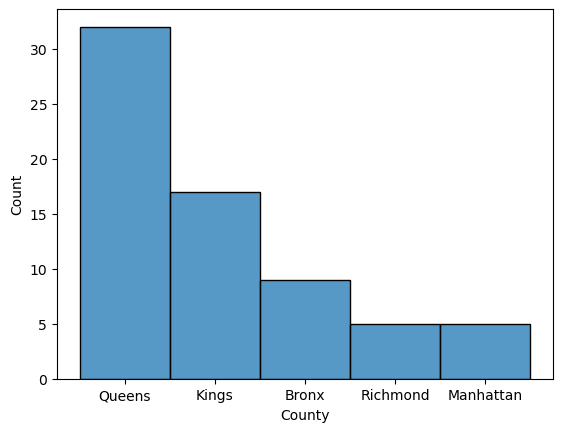

In [9]:
sns.histplot(gdf['County'], stat = 'count')

## Mapping

### Overview

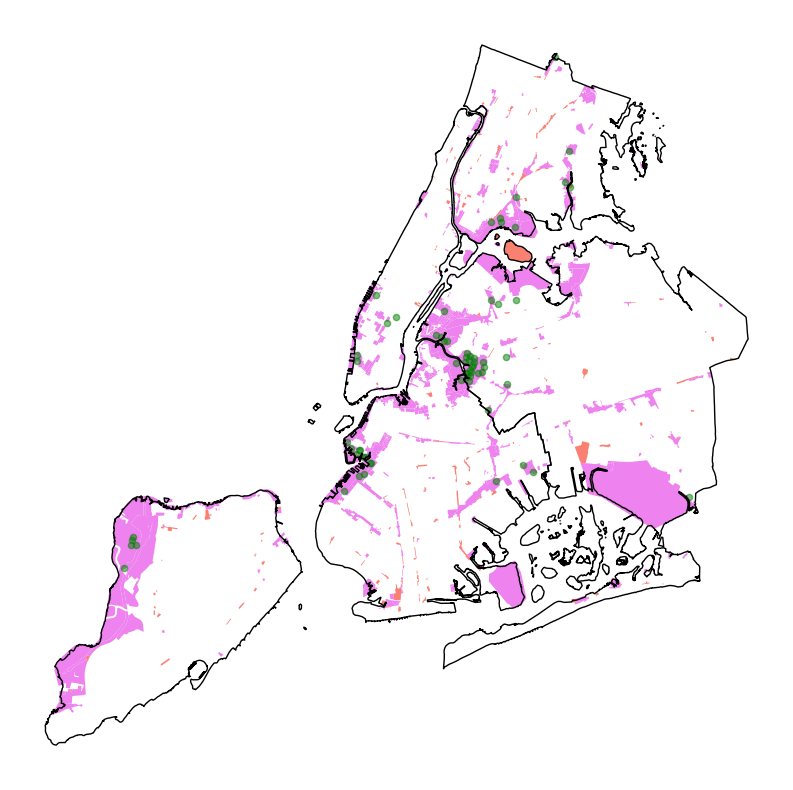

In [10]:
#Mapping the identified last-mile warehouses over the manufacturing zones and C8 zones. 
fig, ax = plt.subplots(figsize = (10,10))

zonesC8.plot(facecolor = 'salmon', edgecolor = 'none', linewidth = 0.6, ax = ax)
zonesM.plot(facecolor = 'violet', edgecolor = 'none', linewidth = 0.6, ax=ax)
gdf.plot(alpha = 0.5, color = 'green', markersize = 20, ax = ax)   
boros.to_crs("EPSG:4326").plot(facecolor = 'none', edgecolor = 'black', linewidth = 1.0, ax = ax)
ax.axis('off');

### Creating a Square Grid

In [11]:
#Create a function that creates a grid of squares
def make_grid(gdf, n_cells):
    gdf = gdf.copy()
    xmin, ymin, xmax, ymax = gdf.total_bounds
    cell_size = (xmax - xmin) / n_cells
   
    #create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax + cell_size, cell_size):
        for y0 in np.arange(ymin, ymax + cell_size, cell_size):
            x1 = x0 - cell_size
            y1 = y0 + cell_size
            grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
    grid = gpd.GeoDataFrame(grid_cells, columns = ['geometry'], crs = gdf.crs)
    return grid

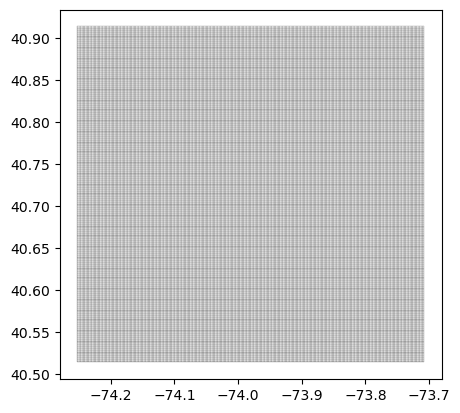

In [12]:
#Generate a grid of squares
grid = make_grid(zonesMandC8, 250)
grid.plot(facecolor='white', edgecolor='black', linewidth=0.1);

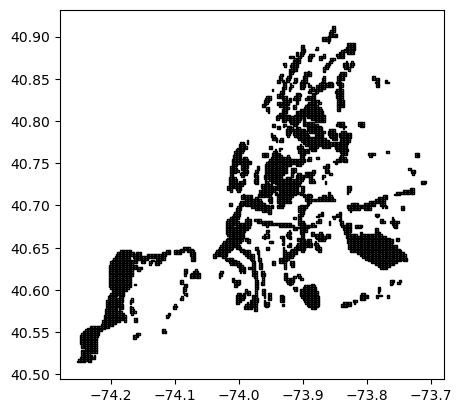

In [13]:
#Keep only the grid cells which intersect with a manufacturing zone or C8 zone
grid_trimmed = gpd.sjoin(grid, zonesMandC8, how='inner', predicate='intersects')

grid_trimmed.plot(facecolor='white', edgecolor='black');

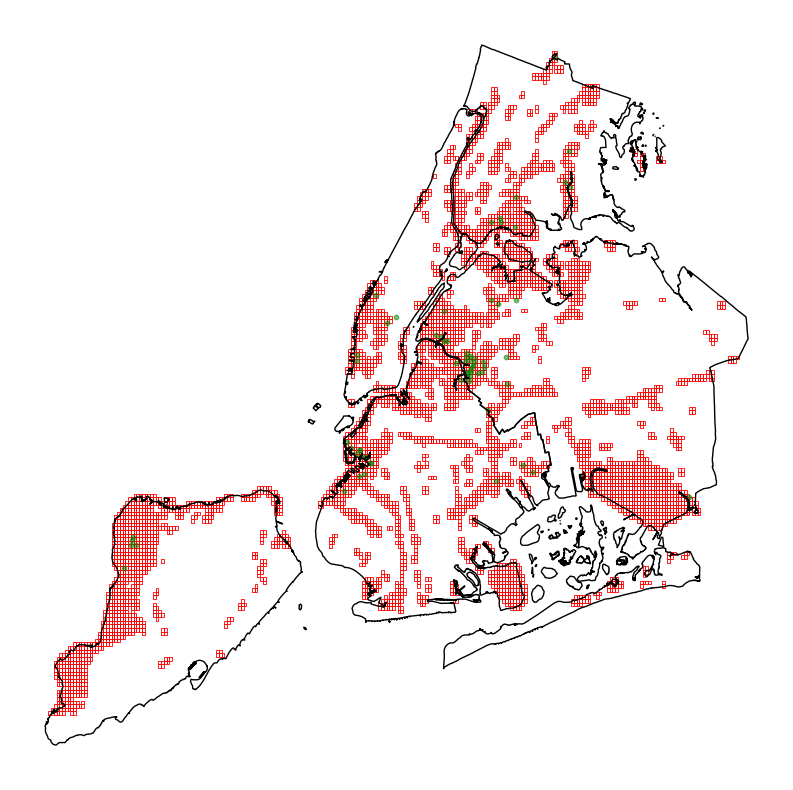

In [14]:
#Just to view the identified last-mile warehouses over the trimmed grid over the manufacturing zones and C8 zones.
fig, ax = plt.subplots(figsize = (10,10))

grid_trimmed.plot(facecolor = 'none', edgecolor = 'red', linewidth = 0.6, ax = ax)
gdf.plot(alpha = 0.5, color = 'green', markersize = 10, ax = ax)    
boros.plot(facecolor = 'none', edgecolor = 'black', linewidth = 1.0, ax = ax)
ax.axis('off');

### Aggregating Over Square Grid

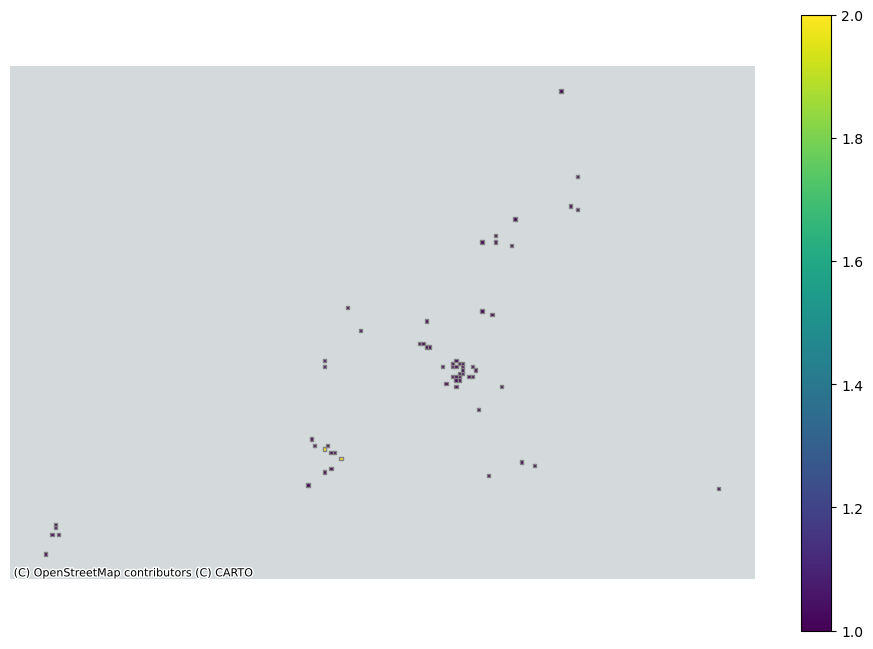

In [15]:
#First we need to remove the index_right column or else the merge will not happen.
grid_trimmed=grid_trimmed.rename(columns ={'index_right':'other_name'})

#Count the number of points per grid cell
merged_sq = gpd.sjoin(gdf, grid_trimmed, how = 'left', predicate = 'within')
merged_sq['n_facilities'] = 1
dissolved_sq = merged_sq.dissolve(by = 'index_right', aggfunc = 'count')
grid_trimmed.loc[dissolved_sq.index, 'n_facilities'] = dissolved_sq.n_facilities.values

#Plot the result
ax = grid_trimmed.plot(column = 'n_facilities', figsize = (12,8), 
                       cmap = 'viridis', edgecolor = 'grey', legend = True)
ax.axis('off')
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron)
plt.show()

In [16]:
#This function aggregates and summarizes point data over a grid
def rasterize(gdf, grid, aggfunc="count", column=None, plot=True):
    merged = gpd.sjoin(gdf, grid, how='left', predicate='within').copy()
    if aggfunc == "count":
        column = 'count'
        output_col = column
        merged[column] = 1
    else:
        output_col = column + "_" + aggfunc   
    dissolved = merged.dissolve(by="index_right", aggfunc=aggfunc)[[column]]
    dissolved.columns = [output_col]
    grid.loc[dissolved.index, output_col] = dissolved[output_col].values
    if plot:
        ax = grid.plot(column=output_col, figsize=(12, 8), edgecolor="grey", legend=True)
        ax.axis('off')
        cx.add_basemap(ax,source=cx.providers.CartoDB.Positron,crs=gdf.crs)
        plt.show()
    return grid

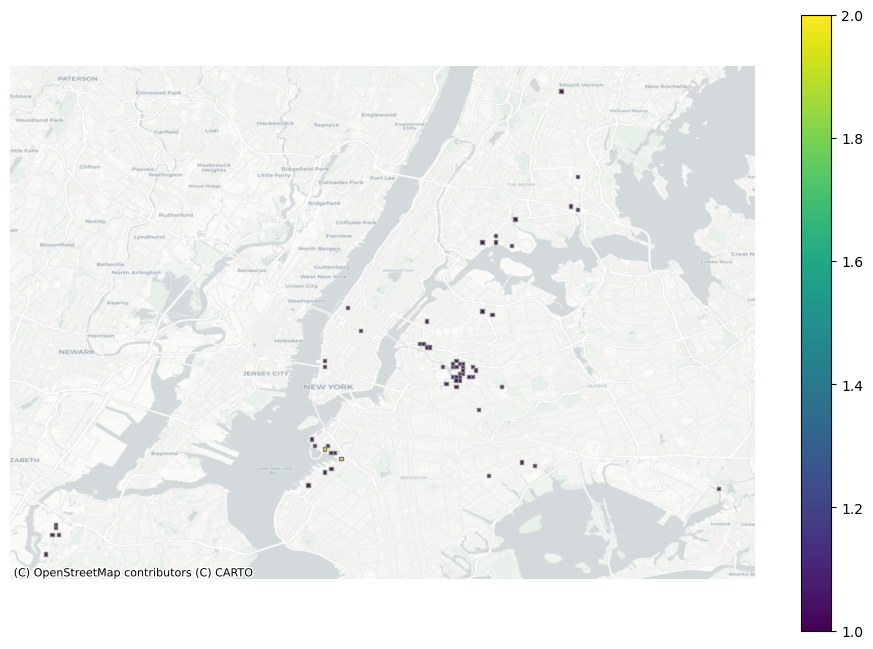

0.0055655758446668865

In [17]:
#Using the rasterize function and calculating the p-value for the chi-square test.
r = rasterize(gdf, grid_trimmed, aggfunc = "count")
stats.chisquare(r['count'].fillna(0)).pvalue

In [18]:
stats.chisquare(r['count'].fillna(0)).pvalue

0.0055655758446668865

### Creating a Hexagon Grid

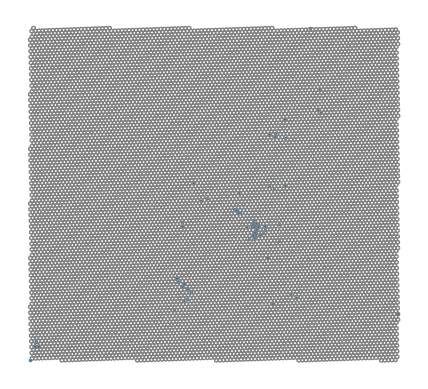

In [19]:
# H3 needs a polygon as input, so use bounding box
bounding_box = gdf.dissolve().envelope[0]
bounding_box = gpd.GeoDataFrame(geometry=[bounding_box])
bounding_box.crs = gdf.crs

hex_grid = h3fy(bounding_box, resolution=9)

ax = gdf.plot(markersize=2)
hex_grid.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=1)
ax.axis('off');

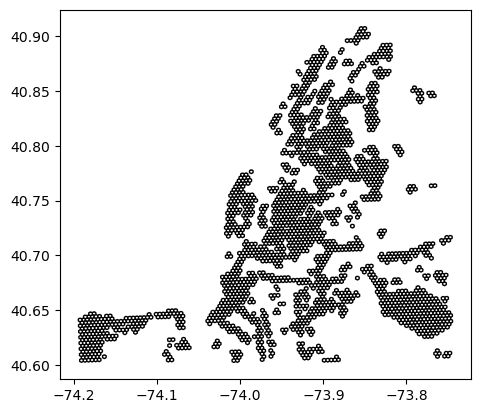

In [20]:
# Keep only the grid cells which intersect with a manufacturing zone or C8 zone
hex_grid_trimmed = gpd.sjoin(hex_grid, zonesMandC8, how='inner', predicate='intersects')

hex_grid_trimmed.plot(facecolor='white', edgecolor='black');

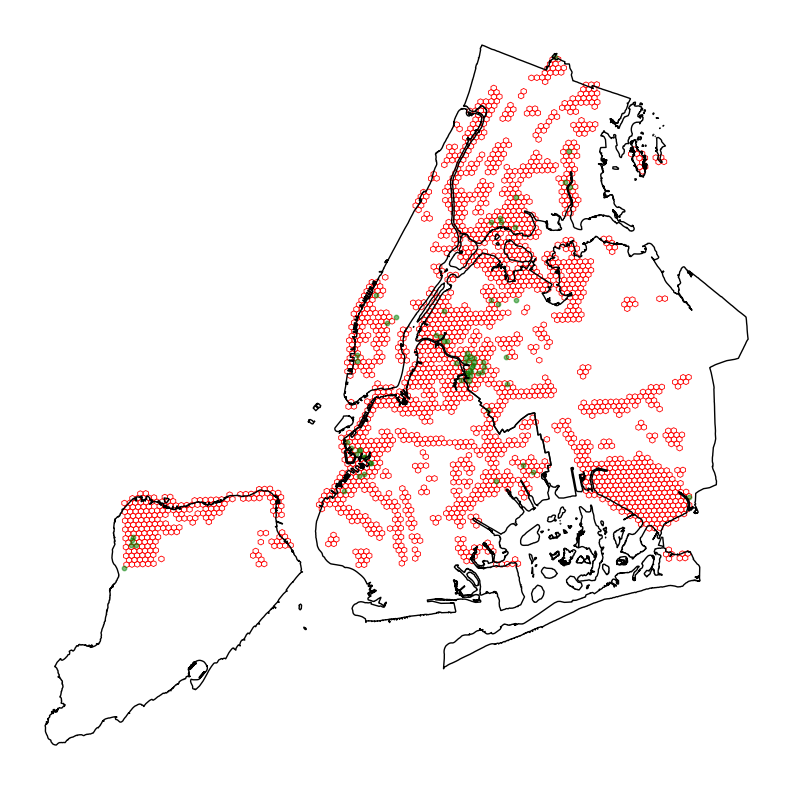

In [21]:
#Just to view the identified last-mile warehouses over the trimmed grid over the manufacturing zones and C8 zones.
fig, ax = plt.subplots(figsize = (10,10))

hex_grid_trimmed.plot(facecolor = 'none', edgecolor = 'red', linewidth = 0.6, ax = ax)
gdf.plot(alpha = 0.5, color = 'green', markersize = 10, ax = ax)    
boros.plot(facecolor = 'none', edgecolor = 'black', linewidth = 1.0, ax = ax)
ax.axis('off');

### Aggregating Over Hexagon Grid

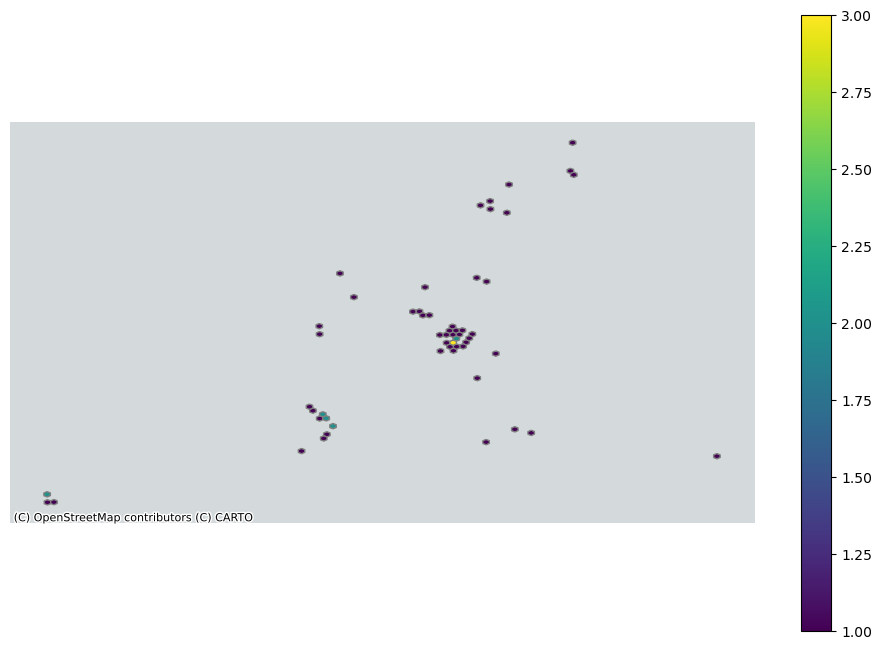

In [22]:
#First we need to remove the index_right column or else the merge will not happen.
hex_grid_trimmed=hex_grid_trimmed.rename(columns ={'index_right':'other_name'})

#Count the number of points per grid cell
merged_hex = gpd.sjoin(gdf, hex_grid_trimmed, how = 'left', predicate = 'within')
merged_hex['n_facilities'] = 1
dissolved_hex = merged_hex.dissolve(by = 'index_right', aggfunc = 'count')
hex_grid_trimmed.loc[dissolved_hex.index, 'n_facilities'] = dissolved_hex.n_facilities.values

#Plot the result
ax = hex_grid_trimmed.plot(column = 'n_facilities', figsize = (12,8), cmap = 'viridis', edgecolor = 'grey', legend = True)
ax.axis('off')
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron)
plt.show()

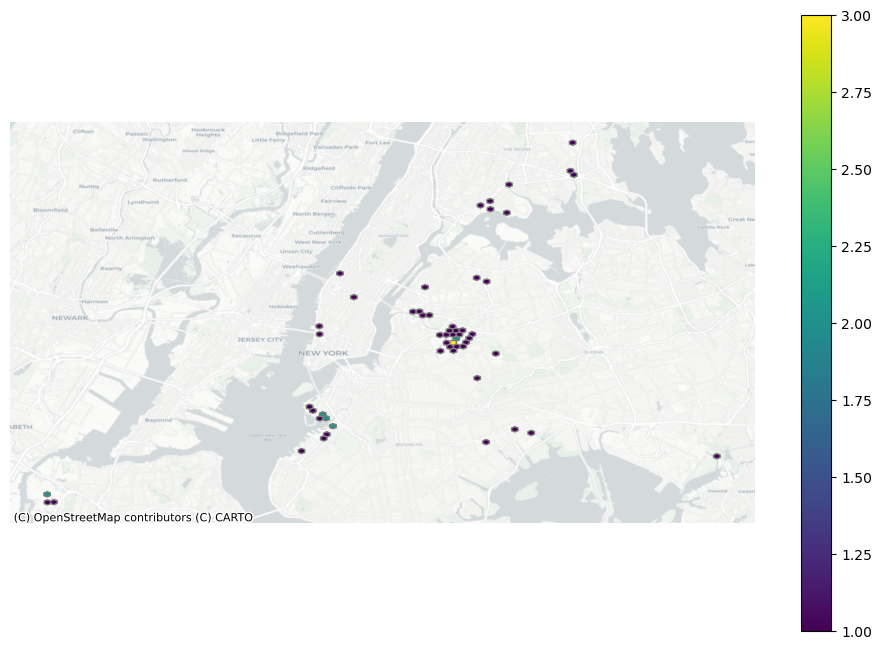

5.29170072338017e-13

In [23]:
#Using the rasterize function and calculating the p-value for the chi-square test.
hex_grid_trimmed = hex_grid_trimmed.reset_index()
r_hex = rasterize(gdf, hex_grid_trimmed, aggfunc = "count")
stats.chisquare(r_hex['count'].fillna(0)).pvalue

In [24]:
stats.chisquare(r_hex['count'].fillna(0)).pvalue

5.29170072338017e-13

## Moran I

In [25]:
#Fill the NA's with zeros
r['count'] = r['count'].fillna(0)

In [26]:
#Generate weights based on Queen-contiguity
w = weights.Queen.from_dataframe(r)

#Row standardize the weights matrix
w.transform = 'R'

('WARNING: ', 792, ' is an island (no neighbors)')
('WARNING: ', 2182, ' is an island (no neighbors)')
('WARNING: ', 3765, ' is an island (no neighbors)')


In [27]:
moran = esda.moran.Moran(r['count'], w, permutations = 9999)

#Calculate the Moran I's statistic
stat = moran.I

#Calculate the simulated p-value of the Moran's I statistic
p_value = moran.p_sim

#Report the results
print("The Moran I's statistic is " + str(stat) + " and the simulated p-value associated with it is " + str(p_value) + ".")

The Moran I's statistic is 0.1119503032486069 and the simulated p-value associated with it is 0.0001.


In [28]:
local_moran = esda.moran.Moran_Local(r['count'], w)
local_moran

In [29]:
# Calculate the local Moran's I statistics and assign them along with their associated p-values and quadrants to each cell
local_moran = esda.moran.Moran_Local(r['count'], w)
r['local_moran_i'] = local_moran.Is
r['local_moran_p_value'] = local_moran.p_sim
r['local_moran_quadrant'] = local_moran.q

In [30]:
# Get the statistically significant clusters and outliers at alpha = 0.10
alpha = 0.05
hotspots = r.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots = r.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts = r.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds = r.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")
not_significant = r.query(f"local_moran_p_value >= {alpha}")


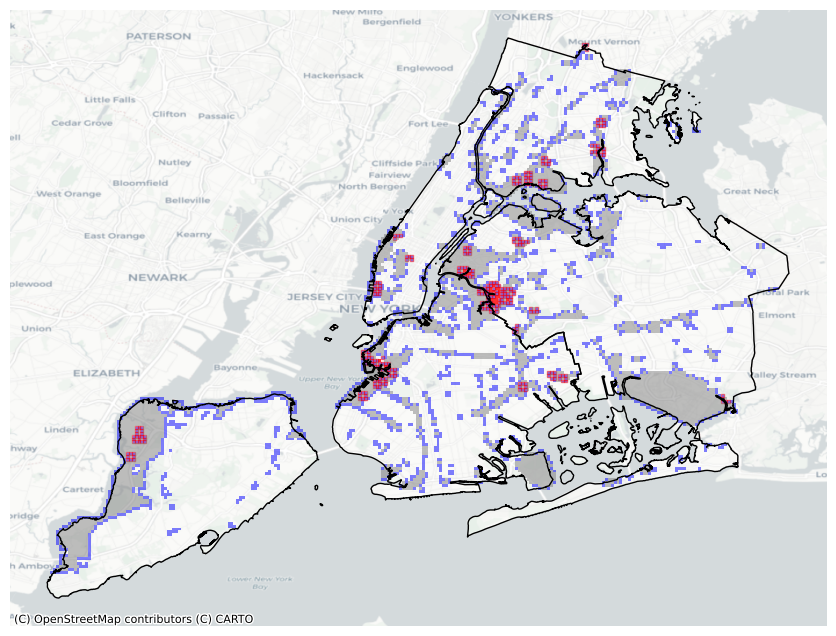

In [31]:
# Plot the hot spots, cold spots, diamonds and doughnuts.
fig, ax = plt.subplots(figsize=(16,8))
hotspots.plot(color='red',alpha=0.8, ax=ax, label='Hot Spot')
coldspots.plot(color='blue', alpha=0.5, ax=ax, label='Cold Spot')
diamonds.plot(color='red', edgecolor='blue', alpha=0.5, ax=ax, label='Diamonds')
doughnuts.plot(color='blue', edgecolor='red', alpha=0.5, ax=ax, label='Doughnuts')
not_significant.plot(color='gray', alpha=0.5, label='Not Significant', ax=ax)
boros.to_crs("EPSG:4326").plot(ax=ax, facecolor = 'none', edgecolor = 'black', linewidth = 1.0)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=4326)
ax.axis('off');

## Ripley's

In [32]:
#get the x and y coordinates
gdf.to_crs(6933)
gdf['x'] = gdf['geometry'].to_crs(6933).x
gdf['y'] = gdf['geometry'].to_crs(6933).y
coords = gdf[['x', 'y']].to_numpy()

In [33]:
def plot_test_results(test_results, input_coords, alpha=1):
    input_coords = input_coords.copy()
    f,ax = plt.subplots(1,2,figsize=(12,6), 
                    gridspec_kw=dict(width_ratios=(6,3)))
    
    # plot all the simulations with very fine lines
    ax[0].plot(test_results.support, test_results.simulations.T, color='k', alpha=.1, linewidth=4)
    # and show the average of simulations
    ax[0].plot(test_results.support, np.median(test_results.simulations, axis=0), color='cyan', linewidth=4, label='median simulation')

    # and the observed pattern's G function
    ax[0].plot(test_results.support, test_results.statistic, label = 'observed', color='red',linewidth=4)
    
    # clean up labels and axes
    ax[0].set_xlabel('distance')
    ax[0].legend()
    ax[0].set_xlim(0,12000)
    test_name = str(type(test_results)).replace("pointpats.distance_statistics.","").split("'")[1].replace("testResult","")    
    ax[0].set_title(f"{test_name}")
    
    # plot the pattern itself on the next frame
    ax[1].scatter(*input_coords.T, alpha)
    # and clean up labels and axes there, too
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_xticklabels([])
    ax[1].set_yticklabels([])
    ax[1].set_title('Observed Point Pattern')
    f.tight_layout()
    plt.show()

#### Ripley's G Test

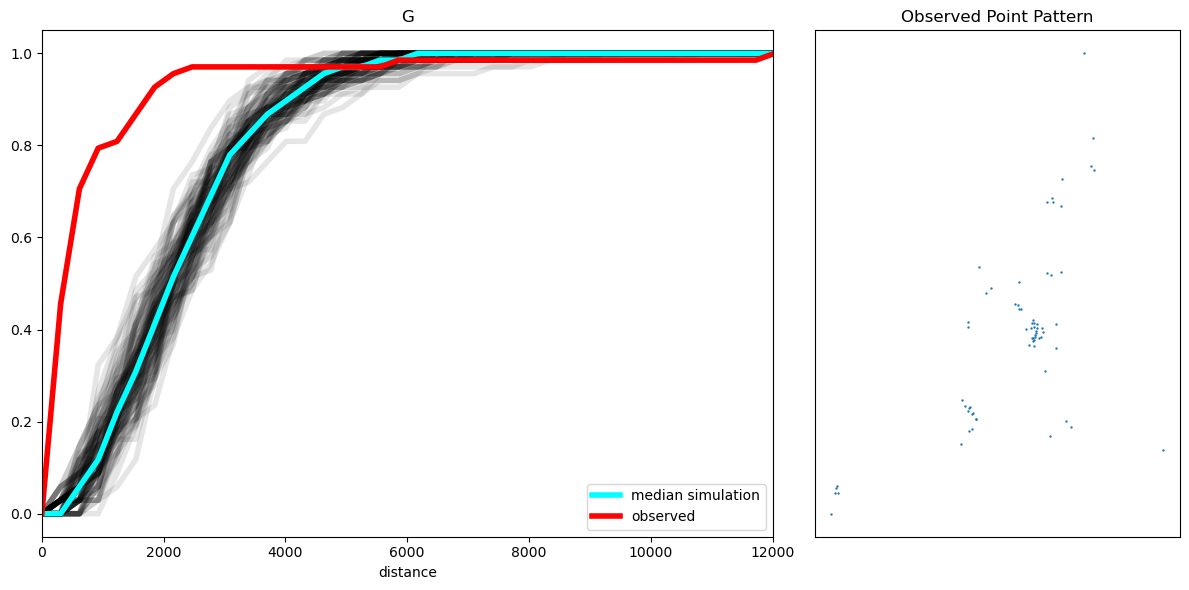

In [34]:
#Ripley's G test
g_test = distance_statistics.g_test(coords, support = 40, keep_simulations = True, n_simulations = 99)

#Plot results
plot_test_results(g_test, coords, alpha=0.5)

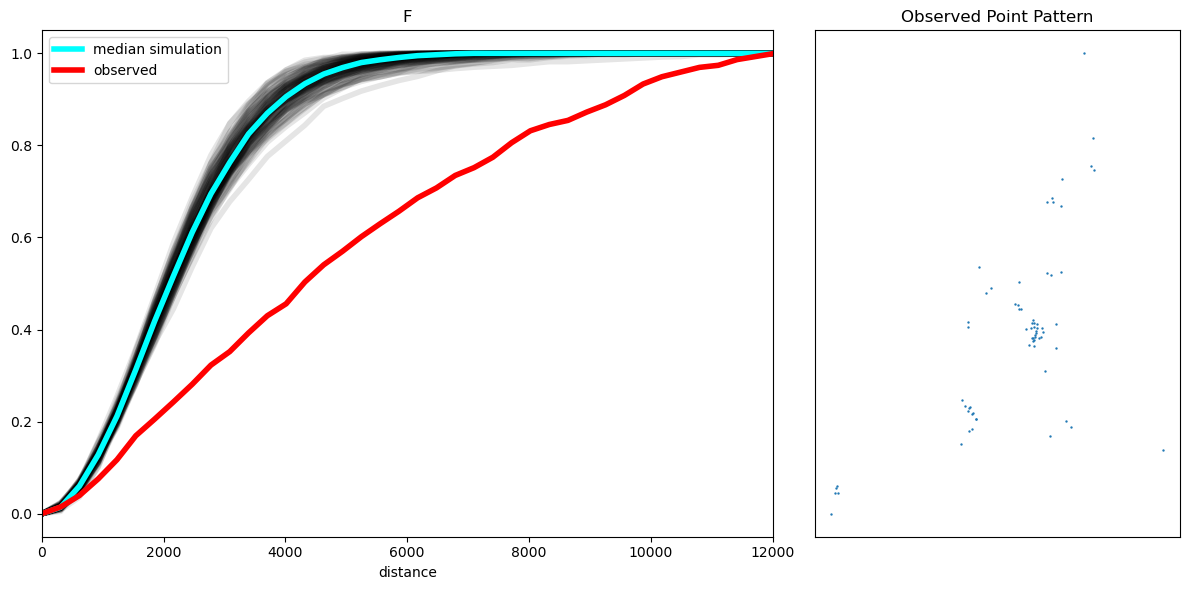

In [35]:
#Ripley's F test
f_test = distance_statistics.f_test(coords, support = 40, keep_simulations = True, n_simulations = 99)

#Plot results
plot_test_results(f_test, coords, alpha=0.5)

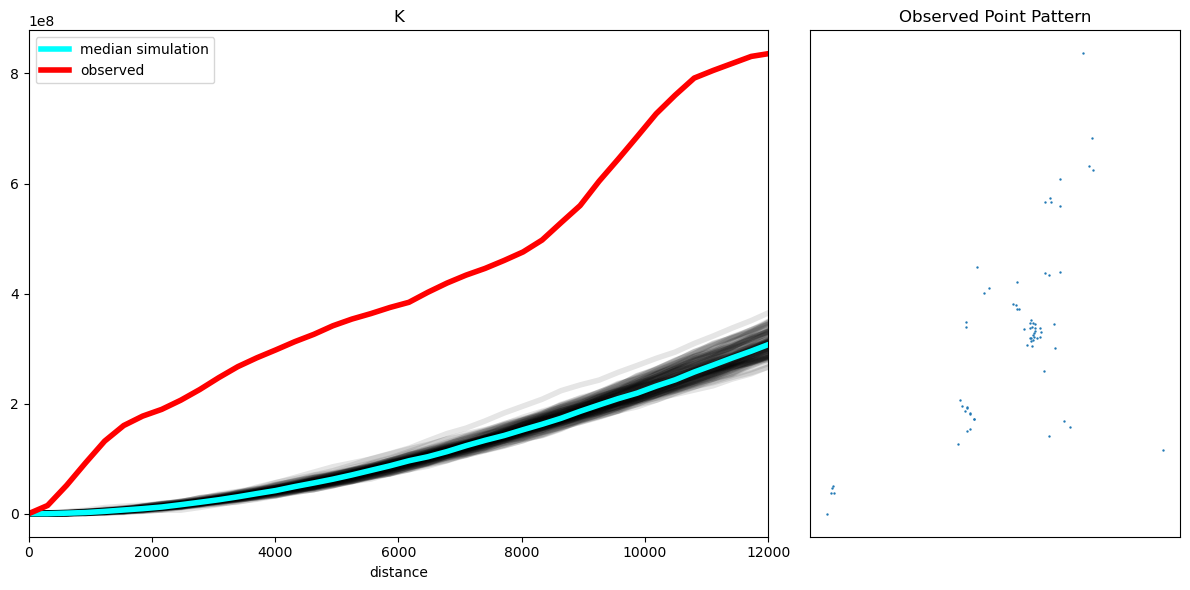

CPU times: total: 219 ms
Wall time: 414 ms


In [36]:
%%time
k_test = distance_statistics.k_test(coords[:5000], support = 40, keep_simulations = True, n_simulations = 99)

plot_test_results(k_test, coords[:5000], alpha = 0.5)